In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import geopandas as gpd
import contextily as cx
import plotly.express as px

from src.data_loader import DataLoader
from src.modeling_tools import *

import warnings
warnings.filterwarnings('ignore')

/Users/lorenza/.local/share/virtualenvs/rmqs_spectra_fractions-5DZEjBGJ/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
output_folder = 'output'
plots_folder = os.path.join(output_folder, 'plots_paper')
os.makedirs(plots_folder, exist_ok=True)

In [3]:
# just plotting parameters to get a nicer font (as in latex)
# the selected font size is quite big, don't hesitate to change these parameters to get nicer plots
%matplotlib inline

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16
# define custom colormaps
norm = matplotlib.colors.Normalize(-1,1)

blue = '#18314F'
orange = '#ec7c2d'
greenYellow = '#B6C649'
blueCyan = '#368F8B'
deepPurple = '#341A31'
violet = '#582C4D'
deepGreen = '#004F2D'

colorlist_70s = [blue, orange, greenYellow, blueCyan, deepPurple, deepGreen, violet]
sns.set_palette(colorlist_70s)

## Load data

In [4]:
data_loader = DataLoader()

### Load RMQS data

In [5]:
sample_data, wavelenths_MIR, mir_spectra = data_loader.run('rmqs')

Loaded 1889 spectra.
1877 spectra after removing organic soils.
1876 spectra after removing samples with RE yield < 0.7 or > 1.3.
1876 spectra after removing samples with layer_upper_limit > 30 cm.


### Load BZE data

In [6]:
sample_data_bze, _, mir_spectra_bze = data_loader.run('bze')

Loaded 463 spectra.
463 spectra after removing organic soils.
449 spectra after removing samples with RE yield < 0.7 or > 1.3.
412 spectra after removing samples with layer_upper_limit > 30 cm.


### Load Finish data

In [7]:
sample_data_finland, _, mir_spectra_finland = data_loader.run('finland')

Loaded 87 spectra.
85 spectra after removing organic soils.
81 spectra after removing samples with RE yield < 0.7 or > 1.3.
81 spectra after removing samples with layer_upper_limit > 30 cm.


## Plot map

In [8]:
sample_data_gdf = gpd.GeoDataFrame(
    sample_data, geometry=gpd.points_from_xy(sample_data.lon, sample_data.lat), crs="EPSG:4326"
).to_crs('EPSG:3857')
sample_data_finland_gdf = gpd.GeoDataFrame(
    sample_data_finland, geometry=gpd.points_from_xy(sample_data_finland.lon, sample_data_finland.lat), crs="EPSG:4326"
).to_crs('EPSG:3857')
sample_data_bze_gdf = gpd.GeoDataFrame(
    sample_data_bze, geometry=gpd.points_from_xy(sample_data_bze.lon, sample_data_bze.lat), crs="EPSG:4326"
).to_crs('EPSG:3857')

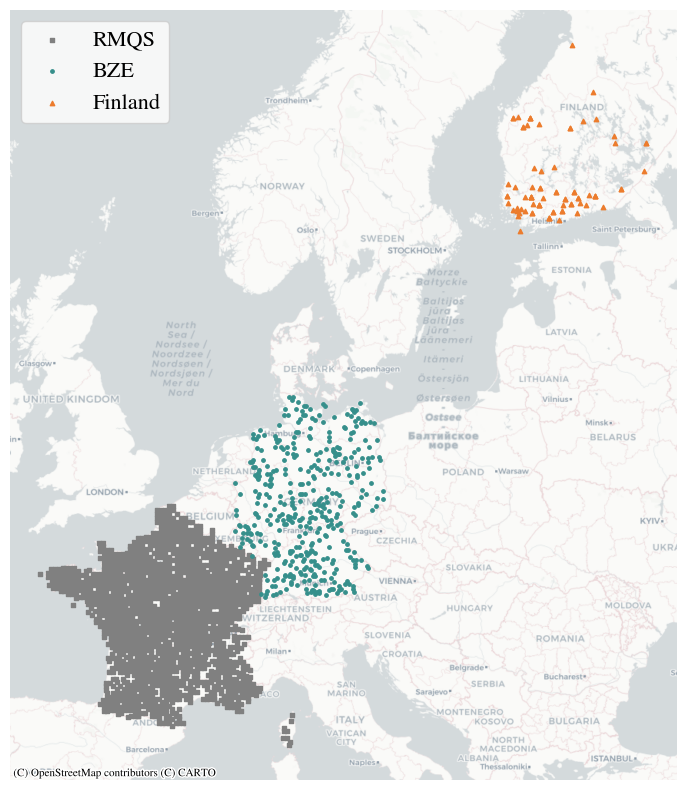

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
sample_data_gdf.plot(ax=ax, markersize=5, color='gray', marker='s', label='RMQS')
sample_data_bze_gdf.plot(ax=ax, markersize=6, color=blueCyan, marker='o', label='BZE')
sample_data_finland_gdf.plot(ax=ax, markersize=10, color=orange, marker='^', label='Finland')
ax.axis('off')
ax.legend()
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)

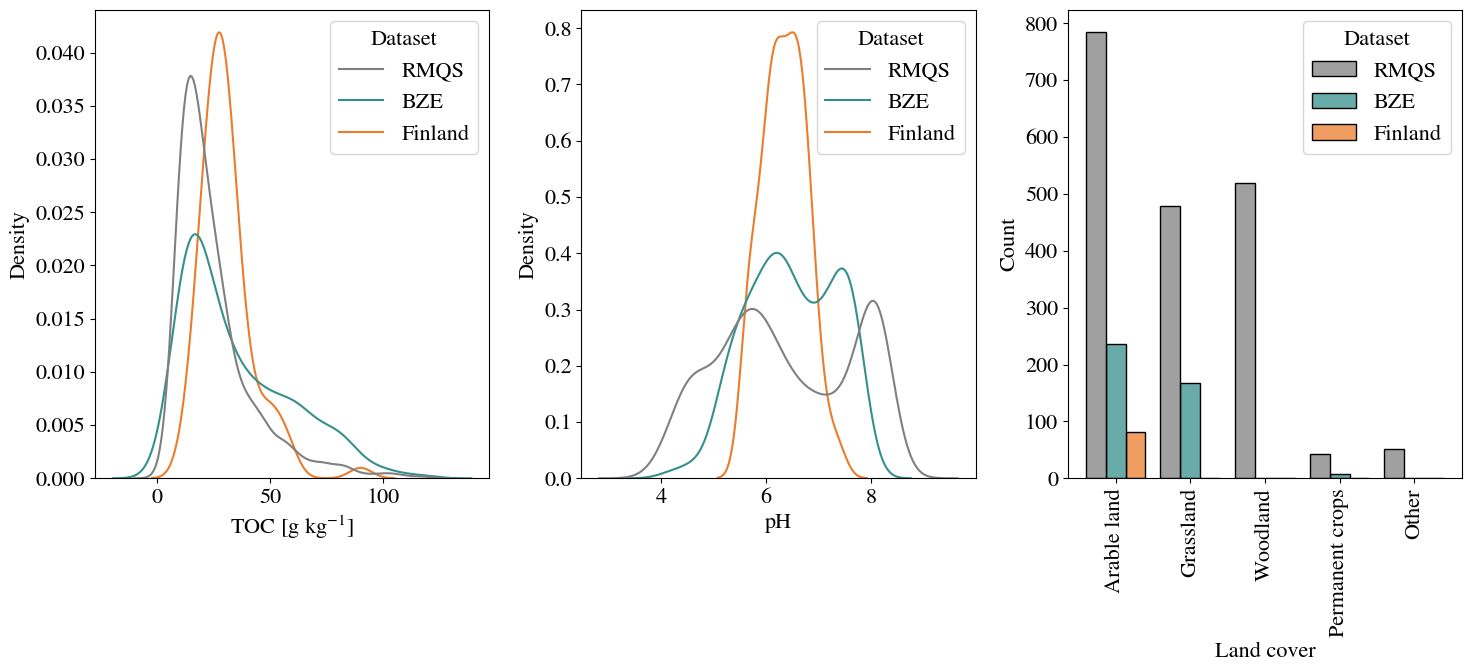

In [13]:
sample_data_gdf['Dataset'] = 'RMQS'
sample_data_bze_gdf['Dataset'] = 'BZE'
sample_data_finland_gdf['Dataset'] = 'Finland'
sample_data = pd.concat([sample_data_gdf, sample_data_bze_gdf, sample_data_finland_gdf])

palette = {
    'RMQS': 'gray',
    'BZE': blueCyan,
    'Finland': orange
}

fig, axs = plt.subplots(1, 3, figsize=(15, 7))

sns.kdeplot(data=sample_data, x='toc', hue='Dataset', palette=palette, ax=axs[0], common_norm=False)
axs[0].set_xlabel('TOC [g kg$^{-1}$]')
sns.kdeplot(data=sample_data, x='ph', hue='Dataset', palette=palette, ax=axs[1], common_norm=False)
axs[1].set_xlabel('pH')
sns.histplot(data=sample_data, x='land_cover', hue='Dataset', palette=palette, ax=axs[2], multiple='dodge', common_norm=False, shrink=0.8)
axs[2].set_xlabel('Land cover')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.savefig(os.path.join(plots_folder, 'distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

In [14]:
fig = px.scatter_ternary(sample_data, a='clay', b='sand', c='silt', color='Dataset', color_discrete_map=palette, width=500, height=500)
fig.write_image(os.path.join(plots_folder, 'texture_triangle.pdf'))
fig.show()

In [10]:
with open(os.path.join(output_folder, 'prediction', 'predictions.p'), "rb") as f:
    mir_predictions_rmqs = pickle.load(f)

In [11]:
with open(os.path.join(output_folder, 'apply_to_bze', 'predictions.p'), "rb") as f:
    mir_predictions_bze = pickle.load(f)

In [12]:
with open(os.path.join(output_folder, 'apply_to_finland', 'predictions.p'), "rb") as f:
    mir_predictions_finland = pickle.load(f)

In [13]:
with open(os.path.join(output_folder, 'apply_to_bze_coral', 'predictions.p'), "rb") as f:
    mir_predictions_bze_coral = pickle.load(f)

In [14]:
with open(os.path.join(output_folder, 'apply_to_finland_coral', 'predictions.p'), "rb") as f:
    mir_predictions_finland_coral = pickle.load(f)

In [15]:
with open(os.path.join(output_folder, 'prediction_bze', 'predictions.p'), "rb") as f:
    mir_predictions_local_model_bze = pickle.load(f)

## Plot model performances

In [25]:
x=mir_predictions_bze['stablecarbon_frac_beta_reg'].y.reshape(-1)
y=mir_predictions_bze['stablecarbon_frac_beta_reg'].y_pred.reshape(-1)
y_ci_lower =mir_predictions_bze['stablecarbon_frac_beta_reg'].y_pred_ci_lower.reshape(-1)
y_ci_upper =mir_predictions_bze['stablecarbon_frac_beta_reg'].y_pred_ci_upper.reshape(-1)

z=mir_predictions_finland['stablecarbon_frac_beta_reg'].y.reshape(-1)
k=mir_predictions_finland['stablecarbon_frac_beta_reg'].y_pred.reshape(-1)
k_ci_lower =mir_predictions_finland['stablecarbon_frac_beta_reg'].y_pred_ci_lower.reshape(-1)
k_ci_upper =mir_predictions_finland['stablecarbon_frac_beta_reg'].y_pred_ci_upper.reshape(-1)

data_germany = pd.DataFrame({'True' : x, "Predicted":y, "CI_lower":y_ci_lower, "CI_upper":y_ci_upper, "Country" :'Germany'})
data_finland = pd.DataFrame({'True' : z, "Predicted":k, "CI_lower":k_ci_lower, "CI_upper":k_ci_upper, "Country" :'Finland'})
data_germany_finland = pd.concat([data_germany, data_finland])
data_germany_finland

,True,Predicted,CI_lower,CI_upper,Country
0,0.3564,0.410727,0.387268,0.434599,Germany
1,0.3278,0.319179,0.298159,0.340961,Germany
2,0.4195,0.517691,0.497144,0.538179,Germany
3,0.4058,0.565805,0.550183,0.581299,Germany
4,0.6211,0.649621,0.635730,0.663263,Germany
...,...,...,...,...,...
76,0.3903,0.557835,0.543362,0.572211,Finland
77,0.3544,0.378175,0.363955,0.392609,Finland
78,0.3675,0.420588,0.407021,0.434275,Finland
79,0.2765,0.369257,0.346287,0.392836,Finland


In [36]:
x=mir_predictions_bze_coral['stablecarbon_frac_beta_reg'].y.reshape(-1)
y=mir_predictions_bze_coral['stablecarbon_frac_beta_reg'].y_pred.reshape(-1)
y_ci_lower =mir_predictions_bze_coral['stablecarbon_frac_beta_reg'].y_pred_ci_lower.reshape(-1)
y_ci_upper =mir_predictions_bze_coral['stablecarbon_frac_beta_reg'].y_pred_ci_upper.reshape(-1)

z=mir_predictions_finland_coral['stablecarbon_frac_beta_reg'].y.reshape(-1)
k=mir_predictions_finland_coral['stablecarbon_frac_beta_reg'].y_pred.reshape(-1)
k_ci_lower =mir_predictions_finland_coral['stablecarbon_frac_beta_reg'].y_pred_ci_lower.reshape(-1)
k_ci_upper =mir_predictions_finland_coral['stablecarbon_frac_beta_reg'].y_pred_ci_upper.reshape(-1)

data_germany_coral = pd.DataFrame({'True' : x, "Predicted":y, "CI_lower":y_ci_lower, "CI_upper":y_ci_upper, "Country" :'Germany'})
data_finland_coral = pd.DataFrame({'True' : z, "Predicted":k, "CI_lower":k_ci_lower, "CI_upper":k_ci_upper, "Country" :'Finland'})
data_germany_finland_coral = pd.concat([data_germany_coral, data_finland_coral])

In [37]:
z=mir_predictions_local_model_bze['stablecarbon_frac_beta_reg'].y_test.reshape(-1)
k=mir_predictions_local_model_bze['stablecarbon_frac_beta_reg'].y_test_pred.reshape(-1)

data_local_model_bze = pd.DataFrame({'True' : z, "Predicted":k})

In [38]:
z=mir_predictions_rmqs['stablecarbon_frac_beta_reg'].y_test.reshape(-1)
k=mir_predictions_rmqs['stablecarbon_frac_beta_reg'].y_test_pred.reshape(-1)
k_ci_lower =mir_predictions_rmqs['stablecarbon_frac_beta_reg'].y_test_pred_ci_lower.reshape(-1)
k_ci_upper =mir_predictions_rmqs['stablecarbon_frac_beta_reg'].y_test_pred_ci_upper.reshape(-1)

data_rmqs = pd.DataFrame({'True' : z, "Predicted":k, "CI_lower":k_ci_lower, "CI_upper":k_ci_upper})

z=mir_predictions_rmqs['stablecarbon_frac_beta_reg'].y.reshape(-1)
k=mir_predictions_rmqs['stablecarbon_frac_beta_reg'].y_pred.reshape(-1)

data_rmqs_train = pd.DataFrame({'True' : z, "Predicted":k})

z=mir_predictions_rmqs['stablecarbon_qty_pls'].y_test.reshape(-1)
k=mir_predictions_rmqs['stablecarbon_qty_pls'].y_test_pred.reshape(-1)

data_rmqs_cs_qty = pd.DataFrame({'True' : z, "Predicted":k})

z=mir_predictions_rmqs['activecarbon_qty_pls'].y_test.reshape(-1)
k=mir_predictions_rmqs['activecarbon_qty_pls'].y_test_pred.reshape(-1)

data_rmqs_ca_qty = pd.DataFrame({'True' : z, "Predicted":k})

z=mir_predictions_rmqs['toc_pls'].y_test.reshape(-1)
k=mir_predictions_rmqs['toc_pls'].y_test_pred.reshape(-1)

data_rmqs_toc = pd.DataFrame({'True' : z, "Predicted":k})

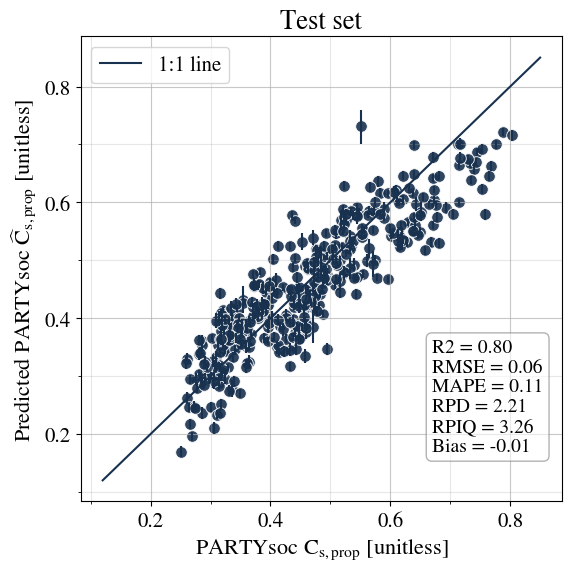

In [ ]:
plt.figure(figsize=(6,6))

ax = sns.lineplot(x=[0.12, 0.85], y=[0.12, 0.85], label="1:1 line")
sns.scatterplot(data=data_rmqs, x="True", y="Predicted", color=blue, s=70, alpha=0.9)

yerr = [data_rmqs["Predicted"] - data_rmqs["CI_lower"], data_rmqs["CI_upper"] - data_rmqs["Predicted"]]
plt.errorbar(data_rmqs["True"], data_rmqs["Predicted"], yerr=yerr, fmt='none', color=blue)

min_x = min([min(data_rmqs['Predicted']), min(data_rmqs['True'])])
max_x = max([max(data_rmqs['Predicted']), max(data_rmqs['True'])])
plt.xlabel('PARTYsoc ${\\mathrm{C}}{_\\mathrm{s,prop}}$ [unitless]')
plt.ylabel('Predicted PARTYsoc $\\widehat{\\mathrm{C}}{_\\mathrm{s,prop}}$ [unitless]')
plt.legend(title='', loc="upper left", fontsize=15)
plt.grid()

scores = mir_predictions_rmqs['stablecarbon_frac_beta_reg']._get_prediction_metrics(data_rmqs['True'], data_rmqs['Predicted'])

txt = '\n'.join([f'{key} = {scores[key]:.2f}' for key in scores])


props = dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='gray')
ax.text(0.73, 0.35, txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

major_xticks = np.arange(0.2, 0.8, 0.2)
minor_xticks = np.arange(0.1, 0.9, 0.1)

ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0)

ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor = True)

ax.set_yticks(major_xticks)
ax.set_yticks(minor_xticks, minor = True)

ax.tick_params(which = 'both', direction = 'out')

# Specify different settings for major and minor grids
ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)
plt.title('Test set')
plt.tight_layout()
plt.savefig(os.path.join(plots_folder, 'stable_carbon_proportion_rmqs.png'), dpi=300)

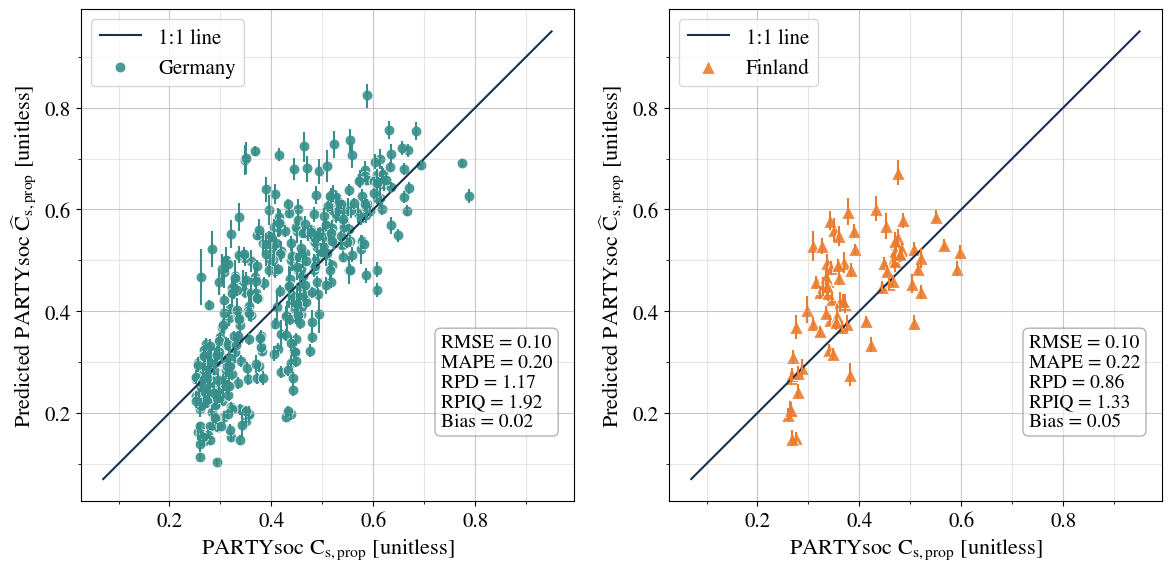

In [40]:
plt.subplots(1,2,figsize=(12,6))

plt.subplot(1,2,1)
ax = sns.lineplot(x=[0.07, 0.95], y=[0.07, 0.95], label="1:1 line")
sns.scatterplot(data=data_germany, x="True", y="Predicted", label="Germany", color=blueCyan, 
                s=60, marker='o', alpha=0.9)

yerr = [data_germany["Predicted"] - data_germany["CI_lower"], data_germany["CI_upper"] - data_germany["Predicted"]]
plt.errorbar(data_germany["True"], data_germany["Predicted"], yerr=yerr, fmt='none', color=blueCyan)

min_x = min([min(data_germany_finland['Predicted']), min(data_germany_finland['True'])])
max_x = max([max(data_germany_finland['Predicted']), max(data_germany_finland['True'])])
plt.xlabel('PARTYsoc ${\\mathrm{C}}{_\\mathrm{s,prop}}$ [unitless]')
plt.ylabel('Predicted PARTYsoc $\\widehat{\\mathrm{C}}{_\\mathrm{s,prop}}$ [unitless]')
plt.legend(title='', loc="upper left", fontsize=15)
plt.grid()

scores = mir_predictions_rmqs['stablecarbon_frac_beta_reg']._get_prediction_metrics(data_germany['True'], data_germany['Predicted'])

txt = '\n'.join([f'{key} = {scores[key]:.2f}' for key in scores if key != 'R2'])


props = dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='gray')
t = ax.text(0.73, 0.34, txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

major_xticks = np.arange(0.2, 0.8, 0.2)
minor_xticks = np.arange(0.1, 0.91, 0.1)

ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0)

ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor = True)

ax.set_yticks(major_xticks)
ax.set_yticks(minor_xticks, minor = True)

ax.tick_params(which = 'both', direction = 'out')

# Specify different settings for major and minor grids
ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)

plt.subplot(1,2,2)
ax = sns.lineplot(x=[0.07, 0.95], y=[0.07, 0.95], label="1:1 line")
sns.scatterplot(data=data_finland, x="True", y="Predicted", label="Finland", color=orange, 
                s=100, marker='^', alpha=0.9)

yerr = [data_finland["Predicted"] - data_finland["CI_lower"], data_finland["CI_upper"] - data_finland["Predicted"]]
plt.errorbar(data_finland["True"], data_finland["Predicted"], yerr=yerr, fmt='none', color=orange)

min_x = min([min(data_germany_finland['Predicted']), min(data_germany_finland['True'])])
max_x = max([max(data_germany_finland['Predicted']), max(data_germany_finland['True'])])
plt.xlabel('PARTYsoc ${\\mathrm{C}}{_\\mathrm{s,prop}}$ [unitless]')
plt.ylabel('Predicted PARTYsoc $\\widehat{\\mathrm{C}}{_\\mathrm{s,prop}}$ [unitless]')
plt.legend(title='', loc="upper left", fontsize=15)
plt.grid()

scores = mir_predictions_rmqs['stablecarbon_frac_beta_reg']._get_prediction_metrics(data_finland['True'], data_finland['Predicted'])

txt = '\n'.join([f'{key} = {scores[key]:.2f}' for key in scores if key != 'R2'])


props = dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='gray')
t = ax.text(0.73, 0.34, txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

major_xticks = np.arange(0.2, 0.8, 0.2)
minor_xticks = np.arange(0.1, 0.91, 0.1)

ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0)

ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor = True)

ax.set_yticks(major_xticks)
ax.set_yticks(minor_xticks, minor = True)

ax.tick_params(which = 'both', direction = 'out')

# Specify different settings for major and minor grids
ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)

plt.tight_layout()
plt.savefig(os.path.join(plots_folder, 'stable_carbon_proportion_transfer_separate_plots.png'), dpi=300, bbox_inches='tight')

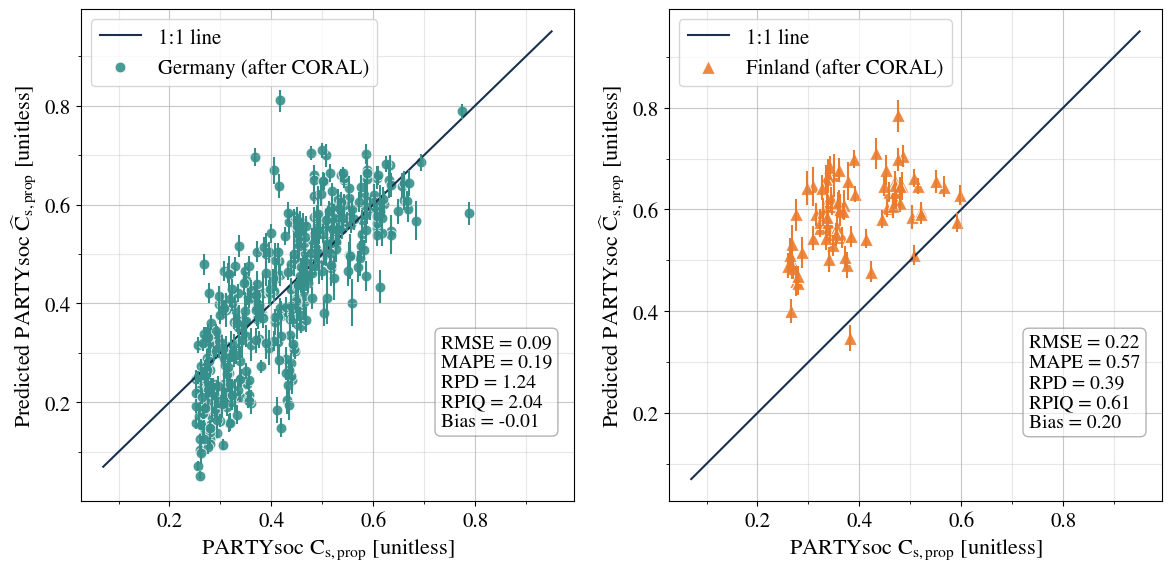

In [42]:
plt.subplots(1,2,figsize=(12,6))

plt.subplot(1,2,1)
ax = sns.lineplot(x=[0.07, 0.95], y=[0.07, 0.95], label="1:1 line")
sns.scatterplot(data=data_germany_coral, x="True", y="Predicted", label="Germany (after CORAL)", color=blueCyan, 
                s=60, marker='o', alpha=0.9)

yerr = [data_germany_coral["Predicted"] - data_germany_coral["CI_lower"], data_germany_coral["CI_upper"] - data_germany_coral["Predicted"]]
plt.errorbar(data_germany_coral["True"], data_germany_coral["Predicted"], yerr=yerr, fmt='none', color=blueCyan)

min_x = min([min(data_germany_finland_coral['Predicted']), min(data_germany_finland_coral['True'])])
max_x = max([max(data_germany_finland_coral['Predicted']), max(data_germany_finland_coral['True'])])
plt.xlabel('PARTYsoc ${\\mathrm{C}}{_\\mathrm{s,prop}}$ [unitless]')
plt.ylabel('Predicted PARTYsoc $\\widehat{\\mathrm{C}}{_\\mathrm{s,prop}}$ [unitless]')
plt.legend(title='', loc="upper left", fontsize=15)
plt.grid()

scores = mir_predictions_rmqs['stablecarbon_frac_beta_reg']._get_prediction_metrics(data_germany_coral['True'], data_germany_coral['Predicted'])

txt = '\n'.join([f'{key} = {scores[key]:.2f}' for key in scores if key != 'R2'])


props = dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='gray')
t = ax.text(0.73, 0.34, txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

major_xticks = np.arange(0.2, 0.8, 0.2)
minor_xticks = np.arange(0.1, 0.91, 0.1)

ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0)

ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor = True)

ax.set_yticks(major_xticks)
ax.set_yticks(minor_xticks, minor = True)

ax.tick_params(which = 'both', direction = 'out')

# Specify different settings for major and minor grids
ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)

plt.subplot(1,2,2)
ax = sns.lineplot(x=[0.07, 0.95], y=[0.07, 0.95], label="1:1 line")
sns.scatterplot(data=data_finland_coral, x="True", y="Predicted", label="Finland (after CORAL)", color=orange, 
                s=100, marker='^', alpha=0.9)

yerr = [data_finland_coral["Predicted"] - data_finland_coral["CI_lower"], data_finland_coral["CI_upper"] - data_finland_coral["Predicted"]]
plt.errorbar(data_finland_coral["True"], data_finland_coral["Predicted"], yerr=yerr, fmt='none', color=orange)

min_x = min([min(data_germany_finland_coral['Predicted']), min(data_germany_finland_coral['True'])])
max_x = max([max(data_germany_finland_coral['Predicted']), max(data_germany_finland_coral['True'])])
plt.xlabel('PARTYsoc ${\\mathrm{C}}{_\\mathrm{s,prop}}$ [unitless]')
plt.ylabel('Predicted PARTYsoc $\\widehat{\\mathrm{C}}{_\\mathrm{s,prop}}$ [unitless]')
plt.legend(title='', loc="upper left", fontsize=15)
plt.grid()

scores = mir_predictions_rmqs['stablecarbon_frac_beta_reg']._get_prediction_metrics(data_finland_coral['True'], data_finland_coral['Predicted'])

txt = '\n'.join([f'{key} = {scores[key]:.2f}' for key in scores if key != 'R2'])


props = dict(boxstyle='round', facecolor='white', alpha=0.6, edgecolor='gray')
t = ax.text(0.73, 0.34, txt, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

major_xticks = np.arange(0.2, 0.8, 0.2)
minor_xticks = np.arange(0.1, 0.91, 0.1)

ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 0)

ax.set_xticks(major_xticks)
ax.set_xticks(minor_xticks, minor = True)

ax.set_yticks(major_xticks)
ax.set_yticks(minor_xticks, minor = True)

ax.tick_params(which = 'both', direction = 'out')

# Specify different settings for major and minor grids
ax.grid(which = 'minor', alpha = 0.3)
ax.grid(which = 'major', alpha = 0.7)

plt.tight_layout()
plt.savefig(os.path.join(plots_folder, 'stable_carbon_proportion_transfer_separate_plots_coral.png'), dpi=300, bbox_inches='tight')